In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import theano, theano.tensor as T
theano.config.floatX='float32'
import lasagne, lasagne.layers as L
import os
from librosa import load, logamplitude
from librosa.feature import melspectrogram
from tqdm import tqdm_notebook
from multiprocessing import Pool
import pickle
from scipy.io.wavfile import read, write

In [2]:
number_of_piano_notes = 88 # on the keyboard

# returns spectrograms and answer vectors for them
def get_data(path):
    data = pickle.load(open(path, "rb"))
    names = [data[i][0] for i in range(len(data))]
    vector = []
    for i in range(len(names)):
        o = np.zeros(88)
        if ".wav" in names[i]:
            names[i] = names[i][:-4]
        for i in names[i].split(","):
            o[int(i)] = 1
        vector.append(o)
    specs = [data[i][1] for i in range(len(data))]
    return vector, specs

In [6]:
midi_one_clear_names, midi_one_clear_specs = get_data("./DATA/s1mc/d0")

midi_one_noised_names, midi_one_noised_specs = get_data("./DATA/s1mn/d0")

real_one_clear_names, real_one_clear_specs = get_data("./DATA/s1rc/d0")

real_one_noised_names, real_one_noised_specs = get_data("./DATA/s1rn/d0")

real_one_clear_names_2, real_one_clear_specs_2 = get_data("./DATA/s1rc2/d0")

signal_one_clear_names, signal_one_clear_specs= get_data("./DATA/s1sc/d0")

IndexError: index 88 is out of bounds for axis 0 with size 88

In [54]:
midi_one_clear_answ = []
for i in range(len(midi_one_clear_names)):
    o = np.zeros(88)
    o[int(midi_one_clear_names[i][:-4]) - 1] = 1
    midi_one_clear_answ.append(o)
    
midi_one_noised_answ = []
for i in range(len(midi_one_noised_names)):
    o = np.zeros(88)
    o[int(midi_one_noised_names[i][:-4]) - 1] = 1
    midi_one_noised_answ.append(o)
    
real_one_clear_answ = []
for i in range(len(real_one_clear_names)):
    o = np.zeros(88)
    o[int(real_one_clear_names[i][:-4]) - 1] = 1
    real_one_clear_answ.append(o)
    
real_one_noised_answ = []
for i in range(len(real_one_noised_names)):
    o = np.zeros(88)
    o[int(real_one_noised_names[i][:-4]) - 1] = 1
    real_one_noised_answ.append(o)
    
real_one_clear_answ_2 = []
for i in range(len(real_one_clear_names_2)):
    o = np.zeros(88)
    o[int(real_one_clear_names_2[i][:-4]) - 1] = 1
    real_one_clear_answ_2.append(o)
    
signal_one_clear_answ = []
for i in range(len(signal_one_clear_names)):
    o = np.zeros(88)
    o[int(signal_one_clear_names[i][:-4]) - 1] = 1
    signal_one_clear_answ.append(o)

In [55]:
X_train = np.concatenate((midi_one_clear_specs, midi_one_noised_specs, real_one_clear_specs, real_one_noised_specs, 
                          signal_one_clear_specs))
y_train = np.concatenate((midi_one_clear_answ, midi_one_noised_answ, real_one_clear_answ, real_one_noised_answ, 
                          signal_one_clear_answ))

In [56]:
X_input_conv_r = T.tensor4("Input X (for conv_r)")
y_target_conv_r = T.matrix("Target y (for conv_r)", dtype='int32')

X_input_conv_f = T.tensor4("Input X (for conv_f)")
y_target_conv_f = T.vector("Target y (for conv_f)", dtype='int32')

disc_input = T.matrix("Disc input")

In [57]:
conv_r = L.InputLayer((None, 1) + X_train.shape[1:])
print(conv_r.output_shape)
conv_r2 = L.Conv2DLayer(conv_r, 20, 3)
print(conv_r2.output_shape)
conv = L.BatchNormLayer(conv_r2)
print(conv.output_shape)
conv_r3 = L.Pool2DLayer(conv, 2)
print(conv_r3.output_shape)
conv_r4 = L.Conv2DLayer(conv_r3, 20, 3)
print(conv_r4.output_shape)
# conv = L.BatchNormLayer(conv_r4)
# print(conv.output_shape)
conv_r5 = L.Pool2DLayer(conv_r4, 2)
print(conv_r5.output_shape)
conv_r_dense = L.DenseLayer(conv_r5, 200)
print(conv_r_dense.output_shape)
# conv = L.DropoutLayer(conv_r_dense, p=0.1)
# print(conv.output_shape)
conv_r6 = L.DenseLayer(conv, 88, nonlinearity=T.nnet.sigmoid)
print(conv_r6.output_shape)

(None, 1, 150, 174)
(None, 20, 148, 172)
(None, 20, 148, 172)
(None, 20, 74, 86)
(None, 20, 72, 84)
(None, 20, 36, 42)
(None, 200)
(None, 88)


In [58]:
disc = L.InputLayer(conv_r_dense.output_shape)
print(disc.output_shape)
disc = L.DenseLayer(disc, 100, nonlinearity=T.nnet.elu)
print(disc.output_shape)
disc = L.DropoutLayer(disc, p=0.1)
disc = L.DenseLayer(disc, 50, nonlinearity=T.nnet.elu)
print(disc.output_shape)
disc = L.BatchNormLayer(disc)
disc = L.DenseLayer(disc, 1, nonlinearity=T.nnet.sigmoid)
print(disc.output_shape)

(None, 200)
(None, 100)
(None, 50)
(None, 1)


In [59]:
y_predicted_conv_r = lasagne.layers.get_output(conv_r6, X_input_conv_r)
y_predicted_conv_r_det = lasagne.layers.get_output(conv_r6, X_input_conv_r, deterministic=True)

y_predicted_conv_f_dense = lasagne.layers.get_output(conv_r_dense, X_input_conv_f)
y_predicted_disc = lasagne.layers.get_output(disc, y_predicted_conv_f_dense)
y_predicted_conv_f_dense_det = lasagne.layers.get_output(conv_r_dense, X_input_conv_f, deterministic=True)
y_predicted_disc_det = lasagne.layers.get_output(disc, y_predicted_conv_f_dense, deterministic=True)

In [60]:
# loss for discriminator: P(real | x real) -> 1, P(real | x fake) -> 0
disc_loss = lasagne.objectives.binary_crossentropy(y_predicted_disc, y_target_conv_f).mean()

# loss for generator: increase P(real | x fake) and  decrease P(real | x real) OVER GENERATOR PARAMS
adv_loss = lasagne.objectives.binary_crossentropy(y_predicted_disc, 1-y_target_conv_f).mean()

conv_r_loss_dense = lasagne.objectives.binary_crossentropy(y_predicted_conv_r, y_target_conv_r).mean()
conv_r_loss_last = conv_r_loss_dense + adv_loss*0.005

In [61]:
disc_acc = lasagne.objectives.binary_accuracy(y_predicted_disc_det, y_target_conv_f).mean()
conv_r_acc = lasagne.objectives.categorical_accuracy(y_predicted_conv_r_det, y_target_conv_r).mean()

In [62]:
disc_weights = lasagne.layers.get_all_params(disc, trainable=True)
disc_updates_adam = lasagne.updates.adam(disc_loss, disc_weights)

conv_r_last_weights = lasagne.layers.get_all_params(conv_r6, trainable=True)
conv_r_last_updates_adam = lasagne.updates.adam(conv_r_loss_last, conv_r_last_weights)

In [63]:
train_r = theano.function([X_input_conv_r, y_target_conv_r, X_input_conv_f, y_target_conv_f], 
                          [conv_r_loss_dense, adv_loss], updates=conv_r_last_updates_adam, allow_input_downcast=True)

In [64]:
train_f = theano.function([X_input_conv_f, y_target_conv_f], disc_loss, updates=disc_updates_adam, allow_input_downcast=True)   

In [65]:
eval_disc = theano.function([X_input_conv_f, y_target_conv_f], disc_acc, allow_input_downcast=True)

In [66]:
eval_conv_r = theano.function([X_input_conv_r, y_target_conv_r], conv_r_acc, allow_input_downcast=True)

In [67]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [68]:
train_r(X_train[:10,None], y_train[:10], X_train[:10,None], np.zeros(len(X_train))[:10])

[array(0.9501712841489774), array(0.8264091879129409)]

In [69]:
print("Disc accuracy:", eval_disc(X_train[:10,None], np.zeros(10)))
print("Conv accuracy:", eval_conv_r(X_train[:10, None], y_train[:10]))

Disc accuracy: 1.0
Conv accuracy: 0.1


In [70]:
specs_midi_clear_names = os.listdir("./DATA/scmc/")
specs_midi_noised_names = os.listdir("./DATA/scmn/")

In [71]:
def get_data(x):
    data = pickle.load(open(x, "rb"))
    names = [data[i][0] for i in range(len(data))]
    names = [i.split("|")[0] for i in names]
    specs = np.asarray([data[i][1][:, :44] for i in range(len(data))])
    specs = np.asarray([np.concatenate((specs[i], specs[i], specs[i], specs[i]), axis = 1)[:, :174] 
                    for i in range(len(specs))])
    
    answ = []
    for i in range(len(names)):
        o = np.zeros(88)
        for i in names[i][:-4].split(","):
            o[int(i) - 21] = 1
        answ.append(o)
    return specs, answ

In [72]:
disc_accs = []
conv_accs = []
neg_conv_accs = []

In [73]:
test_noised_spec, test_noised_answ = get_data("./test_noised")

In [26]:
test_clear_spec, test_clear_answ = get_data("./test_clear")

In [43]:
batchsize=100

for epoch in tqdm_notebook(range(11, 250)):
    
    spec_midi_chords_clear, answ_midi_chords_clear = get_data("./DATA/scmc/" + 
                                                        specs_midi_clear_names[epoch % len(specs_midi_clear_names)])
    spec_midi_chords_noised, answ_midi_chords_noised = get_data("./DATA/scmn/" + 
                                                        specs_midi_noised_names[epoch % len(specs_midi_noised_names)])
    
    x_tr_gen = np.concatenate((spec_midi_chords_clear, X_train))
    y_tr_gen = np.concatenate((answ_midi_chords_clear, y_train))
    
    x_tr_real = np.concatenate((spec_midi_chords_noised, real_one_clear_specs_2, x_tr_gen))
    y_tr_real = np.concatenate((np.ones(len(answ_midi_chords_clear) + len(real_one_clear_answ_2)),
                                np.zeros(len(x_tr_gen))))
    y_tr_real_answ = np.concatenate((answ_midi_chords_noised, real_one_clear_answ_2, y_tr_gen))
    
    indexes = np.arange(len(x_tr_real))
    np.random.shuffle(indexes)
    x_tr_real = [x_tr_real[i] for i in indexes]
    y_tr_real = [y_tr_real[i] for i in indexes]
    y_tr_real_answ = [y_tr_real_answ[i] for i in indexes]
    
    for n, (x_batch,y_batch) in enumerate(iterate_minibatches(x_tr_gen,y_tr_gen,batchsize,shuffle=True)):
        if x_tr_real[n*batchsize : (n+1)*batchsize] == []:
            break
        if n%2 == 0:
            train_r(np.asarray(x_batch)[:,None], y_batch, np.asarray(x_tr_real[n*batchsize : (n+1)*batchsize])[:,None], y_tr_real[n*batchsize : (n+1)*batchsize])   
        train_f(np.asarray(x_tr_real[n*batchsize : (n+1)*batchsize])[:, None], y_tr_real[n*batchsize : (n+1)*batchsize])
    
    if epoch % 5 == 0:
        pickle.dump(conv_r_last_weights, open("conv_r_last_weights_v2_e" + str(epoch), "wb"))
        pickle.dump(disc_weights, open("disc_weights_v2_e" + str(epoch), "wb"))
        
    print("Epoch",epoch)
    disc_accs.append(eval_disc(np.asarray(test_noised_spec)[:len(x_tr_gen)//100,None],np.ones(len(x_tr_gen)//100)))
    print("Disc accuracy:", disc_accs[-1])
    conv_accs.append(eval_conv_r(np.asarray(test_clear_spec)[:len(x_tr_gen)//100,None], test_clear_answ[:len(x_tr_gen)//100]))
    print("Conv accuracy:", conv_accs[-1])
    neg_conv_accs.append(eval_conv_r(np.asarray(test_noised_spec)[:len(x_tr_gen)//100,None], test_noised_answ[:len(x_tr_gen)//100]))
    print("Negative accuracy:", neg_conv_accs[-1])    

100%|██████████| 13/13 [02:05<00:00,  9.44s/it]      | 1/13 [00:19<03:54, 19.52s/it]


Epoch 11
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [02:01<00:00, 10.63s/it]      | 1/13 [00:15<03:01, 15.11s/it]


Epoch 12
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [02:06<00:00, 10.42s/it]      | 1/13 [00:17<03:34, 17.86s/it]


Epoch 13
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [02:11<00:00, 11.14s/it]      | 1/13 [00:17<03:35, 17.94s/it]


Epoch 14
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.7692307692307693
Negative accuracy: 0.7692307692307693


100%|██████████| 13/13 [02:16<00:00, 11.44s/it]      | 1/13 [00:19<03:56, 19.74s/it]


Epoch 15
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.7692307692307693


100%|██████████| 13/13 [02:09<00:00, 10.87s/it]      | 1/13 [00:16<03:21, 16.75s/it]


Epoch 16
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.8461538461538461


100%|██████████| 13/13 [02:08<00:00, 10.85s/it]      | 1/13 [00:17<03:27, 17.27s/it]


Epoch 17
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.7692307692307693
Negative accuracy: 0.7692307692307693


100%|██████████| 13/13 [02:16<00:00, 11.44s/it]      | 1/13 [00:18<03:39, 18.29s/it]


Epoch 18
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.7692307692307693
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [02:17<00:00, 11.64s/it]      | 1/13 [00:18<03:43, 18.61s/it]


Epoch 19
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [02:09<00:00, 10.59s/it]      | 1/13 [00:17<03:34, 17.86s/it]


Epoch 20
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [02:10<00:00, 10.60s/it]      | 1/13 [00:17<03:33, 17.76s/it]


Epoch 21
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.7692307692307693
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [02:08<00:00, 10.84s/it]      | 1/13 [00:17<03:31, 17.60s/it]


Epoch 22
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [02:12<00:00, 10.99s/it]      | 1/13 [00:19<03:49, 19.13s/it]


Epoch 23
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [02:00<00:00,  9.81s/it]      | 1/13 [00:17<03:28, 17.38s/it]


Epoch 24
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [02:01<00:00, 10.67s/it]      | 1/13 [00:14<02:56, 14.75s/it]


Epoch 25
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [02:21<00:00, 11.74s/it]      | 1/13 [00:19<03:50, 19.23s/it]


Epoch 26
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.7692307692307693
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [02:09<00:00, 10.92s/it]      | 1/13 [00:16<03:22, 16.88s/it]


Epoch 27
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.7692307692307693
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [02:02<00:00,  9.66s/it]      | 1/13 [00:17<03:32, 17.68s/it]


Epoch 28
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.7692307692307693
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [02:06<00:00, 10.87s/it]      | 1/13 [00:15<03:00, 15.00s/it]


Epoch 29
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [02:13<00:00, 10.88s/it]      | 1/13 [00:19<03:56, 19.68s/it]


Epoch 30
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [02:01<00:00, 10.22s/it]      | 1/13 [00:16<03:15, 16.30s/it]


Epoch 31
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [02:03<00:00, 10.33s/it]      | 1/13 [00:17<03:30, 17.51s/it]


Epoch 32
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [02:06<00:00, 10.73s/it]      | 1/13 [00:16<03:14, 16.20s/it]


Epoch 33
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [02:14<00:00, 10.44s/it]      | 1/13 [00:19<03:49, 19.12s/it]


Epoch 34
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [01:53<00:00,  9.49s/it]      | 1/13 [00:14<02:57, 14.80s/it]


Epoch 35
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [01:55<00:00, 10.50s/it]      | 1/13 [00:14<02:59, 14.96s/it]


Epoch 36
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [02:06<00:00, 10.42s/it]      | 1/13 [00:16<03:17, 16.49s/it]


Epoch 37
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [02:12<00:00, 11.03s/it]      | 1/13 [00:17<03:30, 17.58s/it]


Epoch 38
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [02:09<00:00, 10.48s/it]      | 1/13 [00:17<03:32, 17.67s/it]


Epoch 39
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [02:05<00:00, 10.44s/it]      | 1/13 [00:16<03:12, 16.05s/it]


Epoch 40
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [02:03<00:00, 10.21s/it]      | 1/13 [00:17<03:29, 17.47s/it]


Epoch 41
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy:

100%|██████████| 13/13 [02:08<00:00, 11.16s/it]      | 1/13 [00:16<03:12, 16.01s/it]


 0.5384615384615384
Epoch 42
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.7692307692307693
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [02:02<00:00, 10.08s/it]      | 1/13 [00:16<03:20, 16.70s/it]


Epoch 43
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [02:01<00:00, 10.33s/it]      | 1/13 [00:16<03:15, 16.31s/it]


Epoch 44
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [02:01<00:00, 10.19s/it]      | 1/13 [00:17<03:28, 17.36s/it]


Epoch 45
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [01:56<00:00,  9.63s/it]      | 1/13 [00:15<03:03, 15.31s/it]


Epoch 46
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:59<00:00, 10.44s/it]      | 1/13 [00:14<02:58, 14.89s/it]


Epoch 47
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [02:06<00:00, 10.53s/it]      | 1/13 [00:17<03:24, 17.05s/it]


Epoch 48
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [02:02<00:00, 10.90s/it]      | 1/13 [00:15<03:07, 15.62s/it]


Epoch 49
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [02:06<00:00, 10.22s/it]      | 1/13 [00:18<03:39, 18.29s/it]


Epoch 50
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:56<00:00,  9.82s/it]      | 1/13 [00:15<03:07, 15.67s/it]


Epoch 51
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:57<00:00,  9.78s/it]      | 1/13 [00:15<03:04, 15.38s/it]


Epoch 52
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [02:00<00:00, 10.26s/it]      | 1/13 [00:16<03:17, 16.46s/it]


Epoch 53
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [02:05<00:00,  9.68s/it]      | 1/13 [00:15<03:08, 15.68s/it]


Epoch 54
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:46<00:00,  8.98s/it]      | 1/13 [00:14<02:48, 14.06s/it]


Epoch 55
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:53<00:00,  9.94s/it]      | 1/13 [00:15<03:03, 15.31s/it]


Epoch 56
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:59<00:00,  9.93s/it]      | 1/13 [00:17<03:30, 17.55s/it]


Epoch 57
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [02:04<00:00, 10.61s/it]      | 1/13 [00:16<03:16, 16.39s/it]


Epoch 58
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [02:00<00:00, 10.15s/it]      | 1/13 [00:16<03:14, 16.24s/it]


Epoch 59
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [02:08<00:00, 11.21s/it]      | 1/13 [00:16<03:14, 16.24s/it]


Epoch 60
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [02:10<00:00, 10.83s/it]      | 1/13 [00:17<03:32, 17.68s/it]


Epoch 61
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [01:59<00:00, 10.20s/it]      | 1/13 [00:15<03:03, 15.30s/it]


Epoch 62
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [02:03<00:00, 10.83s/it]      | 1/13 [00:16<03:12, 16.08s/it]


Epoch 63
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [02:05<00:00, 10.08s/it]      | 1/13 [00:17<03:26, 17.22s/it]


Epoch 64
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:56<00:00, 10.12s/it]      | 1/13 [00:15<03:01, 15.09s/it]


Epoch 65
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [02:01<00:00, 10.28s/it]      | 1/13 [00:16<03:23, 16.99s/it]


Epoch 66
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [02:09<00:00, 10.22s/it]      | 1/13 [00:16<03:17, 16.45s/it]


Epoch 67
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:55<00:00,  9.78s/it]      | 1/13 [00:15<03:03, 15.26s/it]


Epoch 68
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [02:00<00:00, 10.36s/it]      | 1/13 [00:15<03:10, 15.90s/it]


Epoch 69
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [02:05<00:00, 10.69s/it]      | 1/13 [00:17<03:33, 17.81s/it]


Epoch 70
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [02:00<00:00,  9.77s/it]      | 1/13 [00:16<03:20, 16.73s/it]


Epoch 71
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [02:00<00:00, 10.25s/it]      | 1/13 [00:15<03:10, 15.91s/it]


Epoch 72
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [02:02<00:00, 10.86s/it]      | 1/13 [00:14<02:55, 14.63s/it]


Epoch 73
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:59<00:00,  9.45s/it]      | 1/13 [00:16<03:18, 16.57s/it]


Epoch 74
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:54<00:00,  9.70s/it]      | 1/13 [00:14<02:58, 14.85s/it]


Epoch 75
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:50<00:00,  8.72s/it]      | 1/13 [00:15<03:10, 15.85s/it]


Epoch 76
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:42<00:00,  8.74s/it]      | 1/13 [00:13<02:36, 13.07s/it]


Epoch 77
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:54<00:00,  9.75s/it]      | 1/13 [00:14<02:51, 14.25s/it]


Epoch 78
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:59<00:00,  9.74s/it]      | 1/13 [00:16<03:14, 16.23s/it]


Epoch 79
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.7692307692307693


100%|██████████| 13/13 [01:54<00:00,  9.73s/it]      | 1/13 [00:14<02:57, 14.80s/it]


Epoch 80
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:51<00:00,  9.71s/it]      | 1/13 [00:14<02:54, 14.51s/it]


Epoch 81
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:54<00:00,  9.28s/it]      | 1/13 [00:16<03:16, 16.41s/it]


Epoch 82
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:43<00:00,  8.99s/it]      | 1/13 [00:12<02:34, 12.86s/it]


Epoch 83
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:53<00:00,  9.15s/it]      | 1/13 [00:15<03:10, 15.84s/it]


Epoch 84
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:49<00:00,  9.05s/it]      | 1/13 [00:15<03:04, 15.40s/it]


Epoch 85
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:53<00:00,  9.78s/it]      | 1/13 [00:14<02:55, 14.59s/it]


Epoch 86
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [02:01<00:00, 10.07s/it]      | 1/13 [00:15<03:05, 15.47s/it]


Epoch 87
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:55<00:00,  9.37s/it]      | 1/13 [00:16<03:15, 16.29s/it]


Epoch 88
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:47<00:00,  9.25s/it]      | 1/13 [00:14<02:51, 14.27s/it]


Epoch 89
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [02:00<00:00, 10.02s/it]      | 1/13 [00:16<03:20, 16.75s/it]


Epoch 90
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:51<00:00,  9.16s/it]      | 1/13 [00:14<02:57, 14.79s/it]


Epoch 91
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:54<00:00,  9.51s/it]      | 1/13 [00:15<03:10, 15.89s/it]


Epoch 92
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:54<00:00,  9.24s/it]      | 1/13 [00:16<03:19, 16.62s/it]


Epoch 93
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:56<00:00, 10.05s/it]      | 1/13 [00:14<02:55, 14.62s/it]


Epoch 94
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:53<00:00,  9.25s/it]      | 1/13 [00:16<03:12, 16.04s/it]


Epoch 95
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:49<00:00,  9.26s/it]      | 1/13 [00:15<03:00, 15.02s/it]


Epoch 96
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:46<00:00,  9.03s/it]      | 1/13 [00:15<03:01, 15.12s/it]


Epoch 97
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:49<00:00,  9.32s/it]      | 1/13 [00:13<02:46, 13.87s/it]


Epoch 98
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:51<00:00,  9.35s/it]      | 1/13 [00:14<02:54, 14.58s/it]


Epoch 99
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:47<00:00,  8.77s/it]      | 1/13 [00:14<02:58, 14.88s/it]


Epoch 100
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:43<00:00,  8.31s/it]      | 1/13 [00:13<02:37, 13.15s/it]


Epoch 101
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:56<00:00,  9.94s/it]      | 1/13 [00:15<03:04, 15.36s/it]


Epoch 102
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:47<00:00,  8.97s/it]      | 1/13 [00:14<02:57, 14.76s/it]


Epoch 103
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:39<00:00,  7.68s/it]      | 1/13 [00:14<02:49, 14.13s/it]


Epoch 104
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:35<00:00,  8.09s/it]      | 1/13 [00:12<02:26, 12.24s/it]


Epoch 105
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:51<00:00,  9.62s/it]      | 1/13 [00:12<02:35, 12.92s/it]


Epoch 106
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:44<00:00,  8.84s/it]      | 1/13 [00:14<02:51, 14.27s/it]


Epoch 107
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:46<00:00,  9.32s/it]      | 1/13 [00:13<02:38, 13.22s/it]


Epoch 108
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:47<00:00,  8.66s/it]      | 1/13 [00:14<02:59, 14.94s/it]


Epoch 109
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:45<00:00,  8.97s/it]      | 1/13 [00:13<02:43, 13.60s/it]


Epoch 110
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:48<00:00,  9.16s/it]      | 1/13 [00:15<03:01, 15.16s/it]


Epoch 111
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:40<00:00,  8.22s/it]      | 1/13 [00:14<02:52, 14.34s/it]


Epoch 112
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:36<00:00,  8.00s/it]      | 1/13 [00:12<02:34, 12.91s/it]


Epoch 113
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:42<00:00,  8.60s/it]      | 1/13 [00:13<02:41, 13.43s/it]


Epoch 114
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:41<00:00,  8.31s/it]      | 1/13 [00:14<02:48, 14.05s/it]


Epoch 115
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:41<00:00,  8.29s/it]      | 1/13 [00:13<02:42, 13.52s/it]


Epoch 116
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:52<00:00, 10.29s/it]      | 1/13 [00:13<02:39, 13.30s/it]


Epoch 117
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:46<00:00,  8.42s/it]      | 1/13 [00:16<03:19, 16.63s/it]


Epoch 118
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:31<00:00,  7.45s/it]      | 1/13 [00:12<02:28, 12.38s/it]


Epoch 119
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:38<00:00,  8.41s/it]      | 1/13 [00:12<02:27, 12.26s/it]


Epoch 120
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy:

100%|██████████| 13/13 [01:38<00:00,  8.06s/it]      | 1/13 [00:13<02:47, 13.94s/it]


 0.46153846153846156
Epoch 121
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:30<00:00,  7.52s/it]      | 1/13 [00:11<02:15, 11.25s/it]


Epoch 122
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:35<00:00,  8.22s/it]      | 1/13 [00:13<02:37, 13.11s/it]


Epoch 123
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:37<00:00,  7.91s/it]      | 1/13 [00:12<02:34, 12.84s/it]


Epoch 124
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:34<00:00,  7.83s/it]      | 1/13 [00:14<02:51, 14.32s/it]


Epoch 125
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:42<00:00,  8.62s/it]      | 1/13 [00:12<02:35, 12.96s/it]


Epoch 126
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:46<00:00,  8.93s/it]      | 1/13 [00:12<02:33, 12.75s/it]


Epoch 127
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:37<00:00,  7.69s/it]      | 1/13 [00:14<02:49, 14.08s/it]


Epoch 128
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:34<00:00,  7.86s/it]      | 1/13 [00:12<02:31, 12.60s/it]


Epoch 129
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.7692307692307693
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:28<00:00,  7.56s/it]      | 1/13 [00:12<02:29, 12.48s/it]


Epoch 130
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:32<00:00,  7.84s/it]      | 1/13 [00:11<02:14, 11.19s/it]


Epoch 131
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:36<00:00,  8.67s/it]      | 1/13 [00:12<02:24, 12.08s/it]


Epoch 132
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:38<00:00,  8.23s/it]      | 1/13 [00:13<02:38, 13.20s/it]


Epoch 133
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:33<00:00,  7.45s/it]      | 1/13 [00:13<02:38, 13.18s/it]


Epoch 134
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:40<00:00,  9.00s/it]      | 1/13 [00:12<02:30, 12.51s/it]


Epoch 135
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:41<00:00,  8.22s/it]      | 1/13 [00:13<02:40, 13.39s/it]


Epoch 136
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:35<00:00,  7.84s/it]      | 1/13 [00:13<02:36, 13.02s/it]


Epoch 137
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:23<00:00,  7.14s/it]      | 1/13 [00:11<02:17, 11.48s/it]


Epoch 138
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:26<00:00,  7.69s/it]      | 1/13 [00:11<02:15, 11.32s/it]


Epoch 139
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:33<00:00,  7.81s/it]      | 1/13 [00:12<02:28, 12.36s/it]


Epoch 140
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:28<00:00,  7.15s/it]      | 1/13 [00:12<02:30, 12.53s/it]


Epoch 141
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:29<00:00,  7.86s/it]      | 1/13 [00:11<02:20, 11.74s/it]


Epoch 142
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:34<00:00,  7.95s/it]      | 1/13 [00:12<02:25, 12.14s/it]


Epoch 143
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:36<00:00,  8.19s/it]      | 1/13 [00:14<02:51, 14.32s/it]


Epoch 144
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6923076923076923
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:35<00:00,  8.20s/it]      | 1/13 [00:11<02:23, 11.95s/it]


Epoch 145
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:40<00:00,  8.18s/it]      | 1/13 [00:12<02:33, 12.81s/it]


Epoch 146
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy:

100%|██████████| 13/13 [01:30<00:00,  7.23s/it]      | 1/13 [00:12<02:30, 12.53s/it]


 0.5384615384615384
Epoch 147
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:30<00:00,  7.56s/it]      | 1/13 [00:11<02:13, 11.11s/it]


Epoch 148
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:40<00:00,  8.51s/it]      | 1/13 [00:12<02:33, 12.79s/it]


Epoch 149
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:35<00:00,  7.73s/it]      | 1/13 [00:13<02:46, 13.90s/it]


Epoch 150
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:30<00:00,  7.73s/it]      | 1/13 [00:12<02:25, 12.15s/it]


Epoch 151
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:33<00:00,  7.76s/it]      | 1/13 [00:12<02:28, 12.42s/it]


Epoch 152
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:28<00:00,  7.24s/it]      | 1/13 [00:12<02:33, 12.83s/it]


Epoch 153
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:22<00:00,  6.96s/it]      | 1/13 [00:09<01:59,  9.93s/it]


Epoch 154
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:29<00:00,  7.64s/it]      | 1/13 [00:11<02:21, 11.78s/it]


Epoch 155
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:37<00:00,  8.23s/it]      | 1/13 [00:13<02:36, 13.08s/it]


Epoch 156
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:36<00:00,  8.12s/it]      | 1/13 [00:13<02:38, 13.21s/it]


Epoch 157
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:34<00:00,  7.47s/it]      | 1/13 [00:12<02:32, 12.73s/it]


Epoch 158
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:35<00:00,  8.32s/it]      | 1/13 [00:13<02:39, 13.27s/it]


Epoch 159
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:45<00:00,  7.78s/it]      | 1/13 [00:15<03:03, 15.32s/it]


Epoch 160
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [01:33<00:00,  8.00s/it]      | 1/13 [00:11<02:20, 11.70s/it]


Epoch 161
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [01:41<00:00,  8.85s/it]      | 1/13 [00:12<02:33, 12.77s/it]


Epoch 162
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [01:45<00:00,  9.06s/it]      | 1/13 [00:13<02:41, 13.45s/it]


Epoch 163
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:43<00:00,  8.78s/it]      | 1/13 [00:13<02:47, 13.93s/it]


Epoch 164
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:49<00:00,  9.36s/it]      | 1/13 [00:14<02:58, 14.90s/it]


Epoch 165
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:45<00:00,  8.88s/it]      | 1/13 [00:13<02:46, 13.85s/it]


Epoch 166
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:42<00:00,  8.55s/it]      | 1/13 [00:13<02:47, 13.92s/it]


Epoch 167
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:43<00:00,  8.50s/it]      | 1/13 [00:13<02:47, 13.93s/it]


Epoch 168
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:48<00:00,  8.99s/it]      | 1/13 [00:14<02:55, 14.64s/it]


Epoch 169
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:44<00:00,  9.03s/it]      | 1/13 [00:13<02:38, 13.21s/it]


Epoch 170
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:44<00:00,  8.73s/it]      | 1/13 [00:14<02:48, 14.01s/it]


Epoch 171
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:43<00:00,  8.55s/it]      | 1/13 [00:13<02:41, 13.43s/it]


Epoch 172
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:39<00:00,  8.20s/it]      | 1/13 [00:13<02:40, 13.38s/it]


Epoch 173
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:42<00:00,  8.53s/it]      | 1/13 [00:12<02:35, 12.92s/it]


Epoch 174
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:35<00:00,  7.90s/it]      | 1/13 [00:12<02:33, 12.82s/it]


Epoch 175
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:24<00:00,  6.89s/it]      | 1/13 [00:12<02:31, 12.58s/it]


Epoch 176
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:23<00:00,  7.11s/it]      | 1/13 [00:10<02:00, 10.05s/it]


Epoch 177
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:24<00:00,  6.93s/it]      | 1/13 [00:11<02:12, 11.07s/it]


Epoch 178
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:26<00:00,  7.51s/it]      | 1/13 [00:11<02:13, 11.09s/it]


Epoch 179
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:30<00:00,  7.92s/it]      | 1/13 [00:11<02:15, 11.30s/it]


Epoch 180
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:25<00:00,  6.84s/it]      | 1/13 [00:13<02:36, 13.02s/it]


Epoch 181
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:25<00:00,  7.27s/it]      | 1/13 [00:10<02:04, 10.34s/it]


Epoch 182
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:27<00:00,  7.47s/it]      | 1/13 [00:11<02:14, 11.22s/it]


Epoch 183
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:25<00:00,  6.85s/it]      | 1/13 [00:12<02:28, 12.41s/it]


Epoch 184
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:21<00:00,  6.92s/it]      | 1/13 [00:09<01:56,  9.74s/it]


Epoch 185
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:17<00:00,  6.44s/it]      | 1/13 [00:09<01:59,  9.93s/it]


Epoch 186
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:20<00:00,  6.66s/it]      | 1/13 [00:10<02:06, 10.56s/it]


Epoch 187
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:21<00:00,  6.97s/it]      | 1/13 [00:11<02:13, 11.09s/it]


Epoch 188
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:23<00:00,  6.98s/it]      | 1/13 [00:11<02:17, 11.46s/it]


Epoch 189
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:23<00:00,  6.79s/it]      | 1/13 [00:11<02:12, 11.05s/it]


Epoch 190
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:30<00:00,  7.59s/it]      | 1/13 [00:12<02:27, 12.28s/it]


Epoch 191
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:24<00:00,  6.85s/it]      | 1/13 [00:11<02:17, 11.46s/it]


Epoch 192
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:22<00:00,  6.83s/it]      | 1/13 [00:10<02:04, 10.36s/it]


Epoch 193
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:33<00:00,  7.86s/it]      | 1/13 [00:13<02:42, 13.52s/it]


Epoch 194
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:24<00:00,  6.91s/it]      | 1/13 [00:11<02:17, 11.46s/it]


Epoch 195
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:25<00:00,  7.29s/it]      | 1/13 [00:11<02:12, 11.05s/it]


Epoch 196
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:32<00:00,  7.78s/it]      | 1/13 [00:12<02:24, 12.03s/it]


Epoch 197
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:29<00:00,  7.27s/it]      | 1/13 [00:12<02:30, 12.57s/it]


Epoch 198
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:33<00:00,  8.29s/it]      | 1/13 [00:11<02:13, 11.16s/it]


Epoch 199
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:31<00:00,  7.46s/it]      | 1/13 [00:12<02:29, 12.42s/it]


Epoch 200
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:23<00:00,  7.06s/it]      | 1/13 [00:11<02:18, 11.52s/it]


Epoch 201
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:25<00:00,  7.17s/it]      | 1/13 [00:11<02:15, 11.26s/it]


Epoch 202
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:21<00:00,  6.61s/it]      | 1/13 [00:10<02:10, 10.87s/it]


Epoch 203
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:24<00:00,  6.81s/it]      | 1/13 [00:11<02:20, 11.73s/it]


Epoch 204
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:24<00:00,  6.99s/it]      | 1/13 [00:10<02:10, 10.88s/it]


Epoch 205
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:21<00:00,  6.72s/it]      | 1/13 [00:10<02:05, 10.42s/it]


Epoch 206
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:23<00:00,  6.87s/it]      | 1/13 [00:10<02:07, 10.61s/it]


Epoch 207
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [01:21<00:00,  6.78s/it]      | 1/13 [00:10<02:05, 10.43s/it]


Epoch 208
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:20<00:00,  6.64s/it]      | 1/13 [00:10<02:04, 10.36s/it]


Epoch 209
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:18<00:00,  6.26s/it]      | 1/13 [00:10<02:06, 10.55s/it]


Epoch 210
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [01:19<00:00,  6.59s/it]      | 1/13 [00:09<01:56,  9.67s/it]


Epoch 211
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [01:21<00:00,  6.63s/it]      | 1/13 [00:10<02:08, 10.71s/it]


Epoch 212
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [01:21<00:00,  6.74s/it]      | 1/13 [00:10<02:07, 10.64s/it]


Epoch 213
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [01:21<00:00,  6.69s/it]      | 1/13 [00:10<02:09, 10.82s/it]


Epoch 214
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [01:18<00:00,  6.48s/it]      | 1/13 [00:09<01:59,  9.96s/it]


Epoch 215
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [01:14<00:00,  6.00s/it]      | 1/13 [00:10<02:00, 10.01s/it]


Epoch 216
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:16<00:00,  6.65s/it]      | 1/13 [00:09<01:56,  9.69s/it]


Epoch 217
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:18<00:00,  6.64s/it]      | 1/13 [00:09<01:59,  9.94s/it]


Epoch 218
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:26<00:00,  7.19s/it]      | 1/13 [00:11<02:16, 11.36s/it]


Epoch 219
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.6153846153846154
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:18<00:00,  6.48s/it]      | 1/13 [00:11<02:14, 11.22s/it]


Epoch 220
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.38461538461538464


100%|██████████| 13/13 [01:16<00:00,  6.42s/it]      | 1/13 [00:09<01:56,  9.68s/it]


Epoch 221
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:20<00:00,  6.54s/it]      | 1/13 [00:10<02:05, 10.43s/it]


Epoch 222
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:22<00:00,  7.05s/it]      | 1/13 [00:10<02:06, 10.56s/it]


Epoch 223
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:21<00:00,  6.54s/it]      | 1/13 [00:10<02:08, 10.67s/it]


Epoch 224
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:17<00:00,  6.37s/it]      | 1/13 [00:10<02:06, 10.55s/it]


Epoch 225
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:15<00:00,  6.07s/it]      | 1/13 [00:09<01:58,  9.86s/it]


Epoch 226
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:12<00:00,  5.95s/it]      | 1/13 [00:09<01:49,  9.16s/it]


Epoch 227
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:11<00:00,  5.70s/it]      | 1/13 [00:09<01:56,  9.68s/it]


Epoch 228
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:11<00:00,  5.99s/it]      | 1/13 [00:09<01:48,  9.07s/it]


Epoch 229
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:12<00:00,  6.12s/it]      | 1/13 [00:09<01:54,  9.54s/it]


Epoch 230
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:13<00:00,  5.96s/it]      | 1/13 [00:09<01:54,  9.55s/it]


Epoch 231
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:12<00:00,  6.11s/it]      | 1/13 [00:09<01:49,  9.15s/it]


Epoch 232
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:20<00:00,  6.89s/it]      | 1/13 [00:09<01:54,  9.55s/it]


Epoch 233
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:22<00:00,  6.85s/it]      | 1/13 [00:10<02:06, 10.58s/it]


Epoch 234
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.46153846153846156


100%|██████████| 13/13 [01:16<00:00,  6.22s/it]      | 1/13 [00:10<02:03, 10.29s/it]


Epoch 235
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:12<00:00,  6.06s/it]      | 1/13 [00:09<01:51,  9.28s/it]


Epoch 236
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:12<00:00,  5.96s/it]      | 1/13 [00:09<01:51,  9.30s/it]


Epoch 237
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:14<00:00,  6.50s/it]      | 1/13 [00:09<01:51,  9.32s/it]


Epoch 238
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.6923076923076923


100%|██████████| 13/13 [01:14<00:00,  6.09s/it]      | 1/13 [00:09<01:55,  9.62s/it]


Epoch 239
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:14<00:00,  6.24s/it]      | 1/13 [00:09<01:52,  9.34s/it]


Epoch 240
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:15<00:00,  6.24s/it]      | 1/13 [00:09<01:52,  9.37s/it]


Epoch 241
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:13<00:00,  6.03s/it]      | 1/13 [00:09<01:53,  9.47s/it]


Epoch 242
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:12<00:00,  6.18s/it]      | 1/13 [00:08<01:47,  8.95s/it]


Epoch 243
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:15<00:00,  6.23s/it]      | 1/13 [00:10<02:03, 10.30s/it]


Epoch 244
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:12<00:00,  5.82s/it]      | 1/13 [00:09<01:52,  9.37s/it]


Epoch 245
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.6153846153846154


100%|██████████| 13/13 [01:11<00:00,  5.84s/it]      | 1/13 [00:09<01:52,  9.39s/it]


Epoch 246
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:12<00:00,  6.06s/it]      | 1/13 [00:09<01:55,  9.61s/it]


Epoch 247
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:14<00:00,  6.13s/it]      | 1/13 [00:09<01:57,  9.77s/it]


Epoch 248
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384


100%|██████████| 13/13 [01:13<00:00,  6.13s/it]      | 1/13 [00:09<01:53,  9.44s/it]


Epoch 249
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.5384615384615384



In [42]:
pickle.dump(conv_r_last_weights, open("conv_r_last_weights_v2_e" + str(epoch), "wb"))
pickle.dump(disc_weights, open("disc_weights_v2_e" + str(epoch), "wb"))

In [36]:
pickle.dump(conv_r_last_weights, open("conv_r_last_weights_v2", "wb"))

In [37]:
pickle.dump(disc_weights, open("disc_weights_v2", "wb"))

In [75]:
neggg = neg_conv_accs[:52]

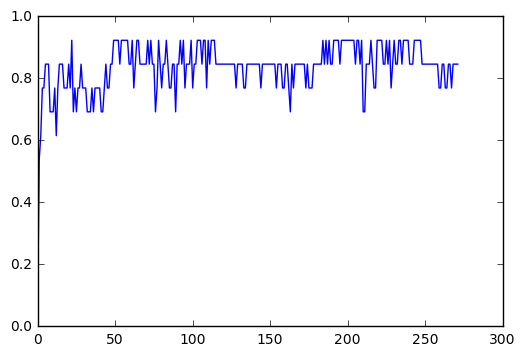

In [44]:
plt.plot(range(len(disc_accs)), disc_accs)

In [76]:
plt.plot(range(len(neg_conv_accs)), h)

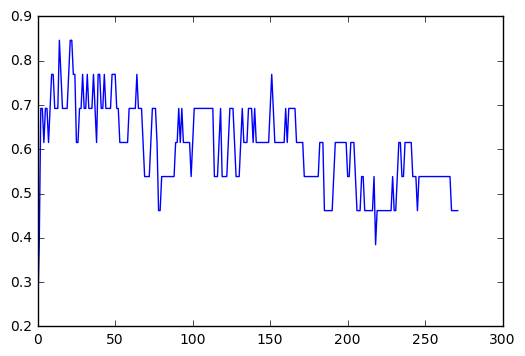

In [46]:
plt.plot(range(len(conv_accs)), conv_accs)

In [48]:
np.mean(neg_conv_accs)

0.55118778280542979

In [49]:
np.mean(conv_accs)

0.60520361990950222

In [50]:
np.mean(disc_accs)

0.83597285067873306